In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
#from google.colab import drive
import gc
import warnings 

/Users/nataliechang/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# train data

In [2]:
train = pd.read_csv("/Users/nataliechang/Desktop/jupy/summerintern2020/train.csv")
train_fraud_ind= train['FRAUD_IND']
train_txkey= train['TXKEY']
train_index= list(train.index)
print(train.shape)
train.head()

(533202, 59)


,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST,FRAUD_IND
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
3,NC0101020170723AAAI7,2017-07-23 02:05:32,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.0,669.0,82190.0,14814.0,65631.0,0.0,0.0,0.0,0.0,1
4,NC0100620170823AAAHS,2017-08-23 02:07:28,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.0,37.0,101607.0,19697.0,29658.0,0.0,0.0,0.0,0.0,1


# test data

In [3]:
test = pd.read_csv("/Users/nataliechang/Desktop/jupy/summerintern2020/test_public.csv")
print(test.shape)
test_txkey = test['TXKEY']
test.head()

(472335, 58)


,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST
0,ES0100920180318AABPO,2018-03-18 14:05:59,295413230391839963354233,5600846000001,8080631190,404378,5499,IP,07,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ES0100A20180318AABQO,2018-03-18 14:11:17,295413230391839963354233,5600846000001,8080631190,404378,5499,IP,07,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VS0I00120180302AABVX,2018-03-02 03:18:24,2444C3130371739903050425,4850893000003,784959000762203,469216,5942,IP,01,0,...,0.7578,0.0,0.0,9620.0,962.0,962.0,0.0,27000.0,27000.0,310.0
3,VS0I00120180302AACO5,2018-03-02 06:32:01,2444C3130371739903050425,4850893000003,244792000205149,469216,4121,IP,01,0,...,0.7578,0.0,0.0,9620.0,962.0,962.0,0.0,27000.0,27000.0,310.0
4,VS0I00120180319AABMI,2018-03-19 03:01:25,214463230340939623034409,3041868000002,248748000103177,469216,5734,IP,01,1,...,0.0897,0.0,0.0,0.0,1331.0,22434.0,0.0,0.0,0.0,0.0


# full data

In [4]:
full_data =  pd.concat((train.loc[:,'TXKEY':'REVOLVING_INTEREST'],
                      test.loc[:,'TXKEY':'REVOLVING_INTEREST']))
print(full_data.shape)
full_data.head()

(1005537, 58)


,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
3,NC0101020170723AAAI7,2017-07-23 02:05:32,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.6044,0.0,669.0,82190.0,14814.0,65631.0,0.0,0.0,0.0,0.0
4,NC0100620170823AAAHS,2017-08-23 02:07:28,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.5310,0.0,37.0,101607.0,19697.0,29658.0,0.0,0.0,0.0,0.0


In [5]:
full_data.tail()

,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST
472330,NC0100F20180320AAHOX,2018-03-20 17:52:50,200553231310439563554159,4250675000002,000812000110705,433604,5812,IP,07,0,...,0.0536,0.0,0.0,0.0,0.0,16072.0,0.0,0.0,0.0,0.0
472331,NC0101020180321AAG1V,2018-03-21 16:57:44,200553231310439563554159,4250675000002,000812000110705,433604,5812,IP,07,0,...,0.0536,0.0,0.0,0.0,0.0,16072.0,0.0,0.0,0.0,0.0
472332,NC0100620180330AAIX1,2018-03-30 19:09:34,200553231310439563554159,4250675000002,000812000110705,433604,5812,IP,07,0,...,0.0536,0.0,0.0,0.0,0.0,16072.0,0.0,0.0,0.0,0.0
472333,NC0100720180331AADJU,2018-03-31 12:15:29,200553231310439563554159,4250675000002,007277445252001,404777,7011,IP,07,0,...,0.0536,0.0,0.0,0.0,0.0,16072.0,0.0,0.0,0.0,0.0
472334,NC0100720180331AAJMB,2018-03-31 19:02:58,269463131302939883954886,4836952000002,8221324400325,3372,5542,IB,01,0,...,0.4165,0.0,0.0,82467.0,9163.0,9163.0,0.0,0.0,0.0,0.0


# NA值處理

In [6]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100*df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:"Missing Values", 1:"% of Total Values"})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values("% of Total Values", ascending=False).round(1)
    
    return mis_val_table_ren_columns

In [7]:
missing_values_table(full_data)

,Missing Values,% of Total Values
PAY_TYPE,979055,97.4
CC_PAY_LEVEL_CODE,92919,9.2
CURRENT_CASH_ADV_AMT,92744,9.2
REVOLVING_AMT,92744,9.2
LST_CYCLE_UNPAID_BAL,92744,9.2
CURRENT_VIO_AMT,92744,9.2
CURRENT_PURCH_AMT,92744,9.2
CURRENT_INSTALLMENT_PURCH_AMT,92744,9.2
CURRENT_INSTALLMENT_BAL,92744,9.2
CURRENT_FEE,92744,9.2


In [8]:
#把缺失值當成一種unknown類別
full_data.fillna(0, inplace=True)
full_data.isnull().sum().sum()

0

# Label Encoding

In [9]:
not_le_col = ['TXKEY','DATETIME']
le_col = full_data.drop(not_le_col, axis=1).columns.tolist()
print(le_col)

['CHID', 'CANO', 'MCHNO', 'ACQIC', 'MCC', 'CONTP', 'ETYMD', 'ECFG', 'INSFG', 'ITERM', 'BNSFG', 'BNSPT', 'FLAM1', 'STOCN', 'SCITY', 'OVRLT', 'PAY_TYPE', 'FALLBACK_IND', 'AGNO', 'CATP1', 'CUORG', 'FEEFG', 'FEDFG', 'CATP2', 'TSCFG', 'LSCFG', 'CGDCT', 'APPFG', 'SAMFG', 'ANDFG', 'AGE', 'CC_CUST_LEVEL', 'CC_VINTAGE', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'MARITAL_STATUS_CODE', 'NATION_CODE', 'OCUP_CODE', 'POSITION_CODE', 'ACCT_VINTAGE', 'AVAILABLE_LIMIT_AMT', 'BONUS_POINTS', 'CC_PAY_LEVEL_CODE', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE', 'CREDIT_USE_RATE', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE', 'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT', 'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'LST_CYCLE_UNPAID_BAL', 'REVOLVING_AMT', 'REVOLVING_INTEREST']


In [10]:
full_data = full_data#.drop(columns=['TXKEY','DATETIME'])
full_data.head()

,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,...,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0
3,NC0101020170723AAAI7,2017-07-23 02:05:32,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.6044,0.0,669.0,82190.0,14814.0,65631.0,0.0,0.0,0.0,0.0
4,NC0100620170823AAAHS,2017-08-23 02:07:28,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,...,0.5310,0.0,37.0,101607.0,19697.0,29658.0,0.0,0.0,0.0,0.0


In [11]:
for i in le_col:
    full_data[i] = full_data[i].apply(str)

In [12]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm
for x_col in tqdm(le_col):
    full_data[x_col] = LabelEncoder().fit_transform(full_data[x_col])

print('%d columns were label encoded.' % len(le_col))
print(le_col)


56 columns were label encoded.
['CHID', 'CANO', 'MCHNO', 'ACQIC', 'MCC', 'CONTP', 'ETYMD', 'ECFG', 'INSFG', 'ITERM', 'BNSFG', 'BNSPT', 'FLAM1', 'STOCN', 'SCITY', 'OVRLT', 'PAY_TYPE', 'FALLBACK_IND', 'AGNO', 'CATP1', 'CUORG', 'FEEFG', 'FEDFG', 'CATP2', 'TSCFG', 'LSCFG', 'CGDCT', 'APPFG', 'SAMFG', 'ANDFG', 'AGE', 'CC_CUST_LEVEL', 'CC_VINTAGE', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'MARITAL_STATUS_CODE', 'NATION_CODE', 'OCUP_CODE', 'POSITION_CODE', 'ACCT_VINTAGE', 'AVAILABLE_LIMIT_AMT', 'BONUS_POINTS', 'CC_PAY_LEVEL_CODE', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE', 'CREDIT_USE_RATE', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE', 'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT', 'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'LST_CYCLE_UNPAID_BAL', 'REVOLVING_AMT', 'REVOLVING_INTEREST']


In [13]:
full_data.head()

,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,11252,92214,47633,5007,167,6,2,1,...,358,39,145,0,128,3783,0,999,0,0
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,11252,92214,47633,5007,167,6,2,1,...,358,39,145,0,128,3783,0,999,0,0
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,11252,92214,47633,5007,167,6,2,1,...,358,39,145,0,128,3783,0,999,0,0
3,NC0101020170723AAAI7,2017-07-23 02:05:32,114267,54179,66334,4472,271,6,2,1,...,6036,39,1489,28819,3535,36368,0,999,0,0
4,NC0100620170823AAAHS,2017-08-23 02:07:28,114267,54179,66334,4472,271,6,2,1,...,5306,39,1093,193,5824,21673,0,999,0,0


In [14]:
#full_data.dtypes

# EDA

In [15]:
def kdeplotByGroup(df,x_col,y_col,group_value):
    sns.kdeplot(df.loc[df[x_col].isin(group_value),y_col],label='isin_group')
    sns.kdeplot(df.loc[~df[x_col].isin(group_value),y_col],label='notin_group')
    plt.legend()
    plt.show()
def kdeplotByValue(df,x_col,y_col):
    g1=df.loc[df[x_col] > df[x_col].mean(),y_col]
    g2=df.loc[df[x_col] < df[x_col].mean(),y_col]
    sns.kdeplot(g1,label=x_col+'>AVG')
    sns.kdeplot(g2,label=x_col+'<AVG')
    print(x_col+' >AVG'+y_col+' AVG:',round(np.mean(g1)*100,2),'%')
    print(x_col+' <AVG'+y_col+' AVG:',round(np.mean(g2)*100,2),'%')
    plt.legend()
    plt.show()

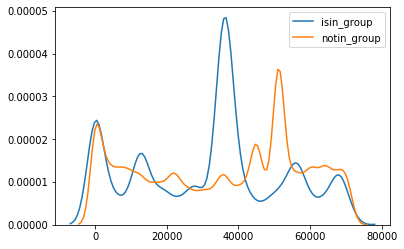

In [16]:
value=[0,5,10,20,33,43,55,68,72,75,81,83,87,89,102,106]
kdeplotByGroup(full_data,'STOCN','FLAM1',value)

# Function for Numeric Aggregations

In [17]:
def agg_function(df,group_var,features):
    agg = df[features+[group_var]].groupby(group_var).agg(['nunique']).reset_index()
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s'%(group_var,var,stat))
    agg.columns = columns
    return agg

# Function to Handle Categorical Variables

In [18]:
def count_categorical(df,group_var,categorical_features):
    categorical = pd.get_dummies(df[categorical_features],columns=categorical_features)
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
        for stat in ['norm_count']:
            column_names.append('%s_%s_%s'%(group_var,var,stat))
    categorical.columns = column_names
    return categorical

Features

In [19]:
features = full_data.columns.tolist()
features = full_data.drop(['TXKEY','DATETIME'],axis=1).columns.tolist()
print(len(features))
print(features)

56
['CHID', 'CANO', 'MCHNO', 'ACQIC', 'MCC', 'CONTP', 'ETYMD', 'ECFG', 'INSFG', 'ITERM', 'BNSFG', 'BNSPT', 'FLAM1', 'STOCN', 'SCITY', 'OVRLT', 'PAY_TYPE', 'FALLBACK_IND', 'AGNO', 'CATP1', 'CUORG', 'FEEFG', 'FEDFG', 'CATP2', 'TSCFG', 'LSCFG', 'CGDCT', 'APPFG', 'SAMFG', 'ANDFG', 'AGE', 'CC_CUST_LEVEL', 'CC_VINTAGE', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE', 'MARITAL_STATUS_CODE', 'NATION_CODE', 'OCUP_CODE', 'POSITION_CODE', 'ACCT_VINTAGE', 'AVAILABLE_LIMIT_AMT', 'BONUS_POINTS', 'CC_PAY_LEVEL_CODE', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE', 'CREDIT_USE_RATE', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE', 'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT', 'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'LST_CYCLE_UNPAID_BAL', 'REVOLVING_AMT', 'REVOLVING_INTEREST']


norm_count_col & nunique_col

In [20]:
# for count nunique
nunique_col = features[:]
# for count each values's norm_count will one hot
norm_count_col = ['CONTP','ECFG','ETYMD','FALLBACK_IND','OVRLT','INSFG','ITERM','PAY_TYPE']

In [21]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df,feats):
    corrs = {} 
    for col in feats:
        corr = df['FRAUD_IND'].corr(df[col])
        corrs[col] = abs(corr)
    return pd.DataFrame(corrs,index=['corr_score']).T.sort_values(by='corr_score',ascending=False)

CANO

In [22]:
new_feat_num = 100

In [23]:
id_col = 'CANO'
full_data = full_data.merge(agg_function(full_data,id_col,list(set(nunique_col)^set([id_col]))),on=id_col,how='left')
print(full_data.shape)
full_data = full_data.merge(count_categorical(full_data,id_col,norm_count_col),on=id_col,how='left')
print(full_data.shape)
gc.collect()

(1005537, 113)
(1005537, 162)


2763

In [25]:
#new_feats = list(set(full_data.drop(['TXKEY'],axis=1).columns)^set(features))
#new_corrs = target_corrs(full_data.loc[full_data['TXKEY'].isin(train_txkey),:].join(train_fraud_ind),new_feats)
#select_feats = features + list(new_corrs.head(new_feat_num).index)
#full_data = full_data[select_feats+['TXKEY']]

ACQIC

In [26]:
id_col = 'ACQIC' 
full_data = full_data.merge(agg_function(full_data,id_col,list(set(nunique_col)^set([id_col]))),on=id_col,how='left')
print(full_data.shape)
gc.collect()
full_data = full_data.merge(count_categorical(full_data,id_col,norm_count_col),on=id_col,how='left')
print(full_data.shape)
gc.collect()

(1005537, 217)
(1005537, 266)


0

MCHNO

In [27]:
id_col = 'MCHNO'
full_data = full_data.merge(agg_function(full_data,id_col,list(set(nunique_col)^set([id_col]))),on=id_col,how='left')
print(full_data.shape)
gc.collect()
full_data = full_data.merge(count_categorical(full_data,id_col,norm_count_col),on=id_col,how='left')
print(full_data.shape)
gc.collect()

(1005537, 321)
(1005537, 370)


0

CHECK

In [28]:
print(full_data.shape)
print(full_data.isnull().sum().sum())
full_data.head()

(1005537, 370)
0


,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,...,MCHNO_ITERM_10_norm_count,MCHNO_ITERM_11_norm_count,MCHNO_ITERM_12_norm_count,MCHNO_ITERM_13_norm_count,MCHNO_PAY_TYPE_0_norm_count,MCHNO_PAY_TYPE_1_norm_count,MCHNO_PAY_TYPE_2_norm_count,MCHNO_PAY_TYPE_3_norm_count,MCHNO_PAY_TYPE_4_norm_count,MCHNO_PAY_TYPE_5_norm_count
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,11252,92214,47633,5007,167,6,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,11252,92214,47633,5007,167,6,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,11252,92214,47633,5007,167,6,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
3,NC0101020170723AAAI7,2017-07-23 02:05:32,114267,54179,66334,4472,271,6,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
4,NC0100620170823AAAHS,2017-08-23 02:07:28,114267,54179,66334,4472,271,6,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0


split to train and test

In [29]:
train = full_data.loc[full_data['TXKEY'].isin(train_txkey),:]
train['FRAUD_IND'] = train_fraud_ind
print(train.shape)

(533202, 371)


/Users/nataliechang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
test = full_data.loc[full_data['TXKEY'].isin(test_txkey),:]
print(test.shape)

(472335, 370)


In [31]:
del full_data
gc.collect()

80

# Model

In [32]:
#creating matrices for sklearn:
X_train = train.drop(columns=['TXKEY','DATETIME','FRAUD_IND'])
#X_train = X_train[['parking_price','txn_dt','building_area','house_age','land_area']]
X_test = test.drop(columns=['TXKEY','DATETIME'])
#X_test = X_test[['parking_price','txn_dt','building_area','house_age','land_area']]
#y = train.total_price
y = train['FRAUD_IND']

In [33]:
df = train.sample(frac=1)
# amount of fraud classes 492 rows.
fraud_df = df.loc[df['FRAUD_IND'] == 1]
non_fraud_df = df.loc[df['FRAUD_IND'] == 0][:76721]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
#new_df.head()
X_train = new_df.drop(columns=['TXKEY','DATETIME','FRAUD_IND'])
y = new_df['FRAUD_IND']
X_train.head()
y.head()

53918    1
73312    1
40504    1
61504    1
50388    1
Name: FRAUD_IND, dtype: int64

In [34]:
# New_df is from the random undersample data (fewer instances)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

Validation

In [35]:
X_val.head()

,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,INSFG,ITERM,...,MCHNO_ITERM_10_norm_count,MCHNO_ITERM_11_norm_count,MCHNO_ITERM_12_norm_count,MCHNO_ITERM_13_norm_count,MCHNO_PAY_TYPE_0_norm_count,MCHNO_PAY_TYPE_1_norm_count,MCHNO_PAY_TYPE_2_norm_count,MCHNO_PAY_TYPE_3_norm_count,MCHNO_PAY_TYPE_4_norm_count,MCHNO_PAY_TYPE_5_norm_count
529508,57544,35775,4505,5021,236,6,4,0,0,0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0,0.0,0.0
272044,23700,135107,13558,5012,256,6,6,0,0,0,...,0.0,0.0,0.0,0.0,0.823529,0.176471,0.0,0,0.0,0.0
39921,42985,128948,42735,5105,432,6,0,0,0,0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0,0.0,0.0
44822,73043,56025,39498,2404,358,6,10,1,0,0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0,0.0,0.0
286379,70469,30959,356,3273,428,6,0,0,0,0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0,0.0,0.0


lightGBM

In [36]:
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from lightgbm import LGBMRegressor
lgb_regressor=lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=500, 
                                learning_rate=0.0025, n_estimators=4000, max_bin=500, bagging_fraction=0.8,
                                bagging_freq=5, bagging_seed=9, feature_fraction=0.7, feature_fraction_seed=9, 
                                min_data_in_leaf=6, min_sum_hessian_in_leaf = 10, reg_lambda=0.1, n_jobs=-1)
lgb_regressor.fit(X_train,y_train)
y_head=lgb_regressor.predict(X_val)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_val,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_val,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_val,y_head))

----------LGBM----------
R square Accuracy:  0.9801967719850949
Mean Absolute Error Accuracy:  0.01352837316701814
Mean Squared Error Accuracy:  0.004950583946313506


In [37]:
y_val = y_val.tolist()
y_head = y_head.tolist()

In [38]:
y_head = [1 if x > 0.99 else 0 for x in y_head]

In [39]:
from sklearn.metrics import f1_score
print(f1_score(y_val,y_head, average='micro'))
print(f1_score(y_val,y_head, average='weighted'))

0.9536005213424569
0.9534870599230211


Test

In [40]:
y_test = lgb_regressor.predict(X_test)
y_test = y_test.tolist()

In [41]:
y_test = [1 if x > 0.99 else 0 for x in y_test]

In [42]:
print(y_test)

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

In [43]:
y_test.count(1)/len(y_test)

0.028683032169964113

In [44]:
len(y_test)

472335

In [45]:
solution = pd.DataFrame({"TXKEY":test.TXKEY, "FRAUD_IND":y_test})
solution.head()
solution.to_csv("credit_sol.csv", index = False)

ImportError: cannot import name 'StringIO' from 'pandas.compat' (/Users/nataliechang/opt/anaconda3/lib/python3.7/site-packages/pandas/compat/__init__.py)

Catboost

In [182]:
cate_features_index = np.where(X_train.dtypes != float)[0]
cate_features_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 264, 265, 266,
       267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 27

In [180]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    class_weights = [1.0,2.5],#因為樣本不平衡,盜刷樣本比較少
    #learning_rate = 0.1/2, #學習率,不設定catboost會自己set
    iterations = 250,# 跑幾次迭代,250次,省時間
    loss_function = 'Logloss',#因為是二分類問題
    eval_metric = 'F1',#主辦單位指定評估指標
    use_best_model = True,#使用最好model
    random_seed = 42,#設定隨機種子
    task_type="GPU",#用GPU加速
    )

In [181]:
model.fit(X_train, y_train, #訓練資料
          eval_set = (X_val, y_val), #val_1當驗證資料
          cat_features = cate_features_index, #指定類別特徵索引
          )

CatBoostError: catboost/libs/train_lib/train_model.cpp:916: Can't load GPU learning library. Module was not compiled or driver  is incompatible with package. Please install latest NVDIA driver and check again